In [1]:
import cv2
import numpy as np

Number of Keypoints Detected In The Training Image:  53245
Number of Keypoints Detected In The Query Image:  3171


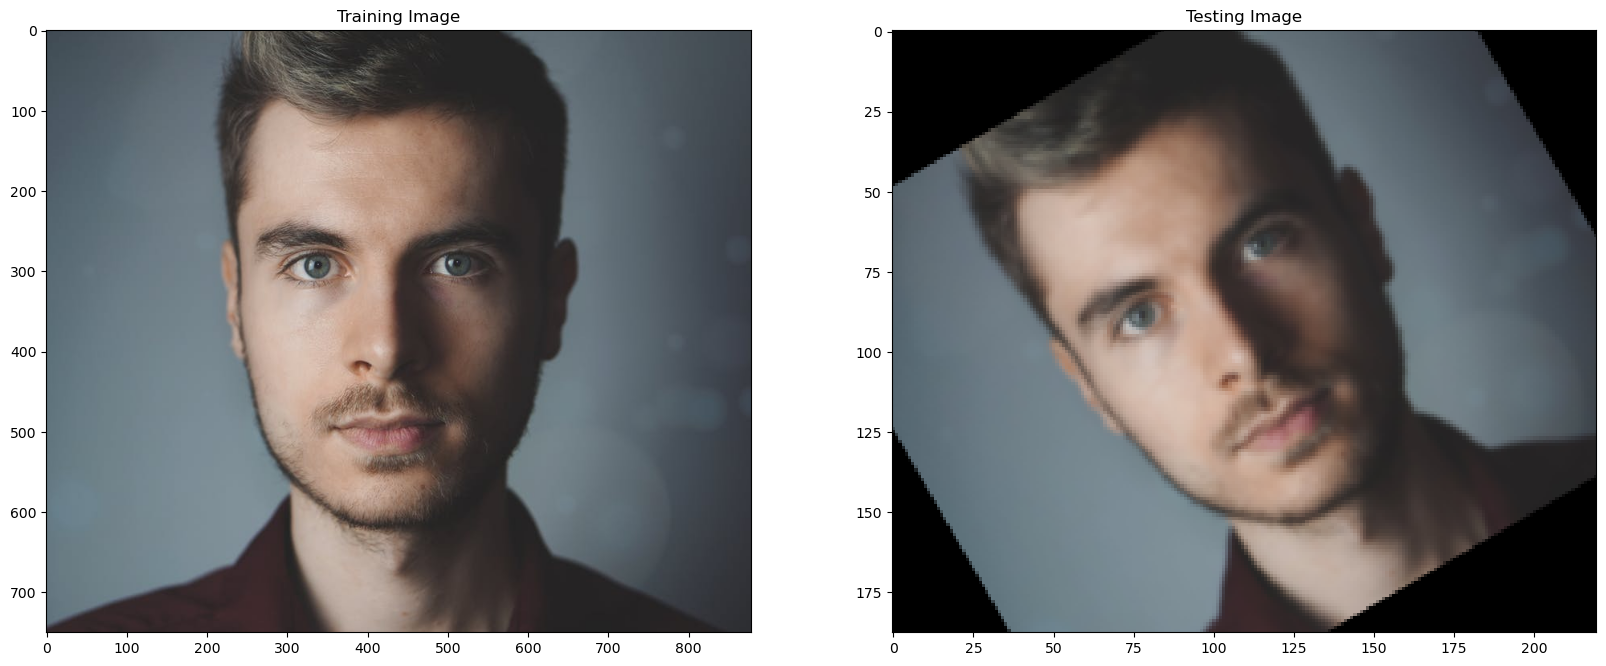

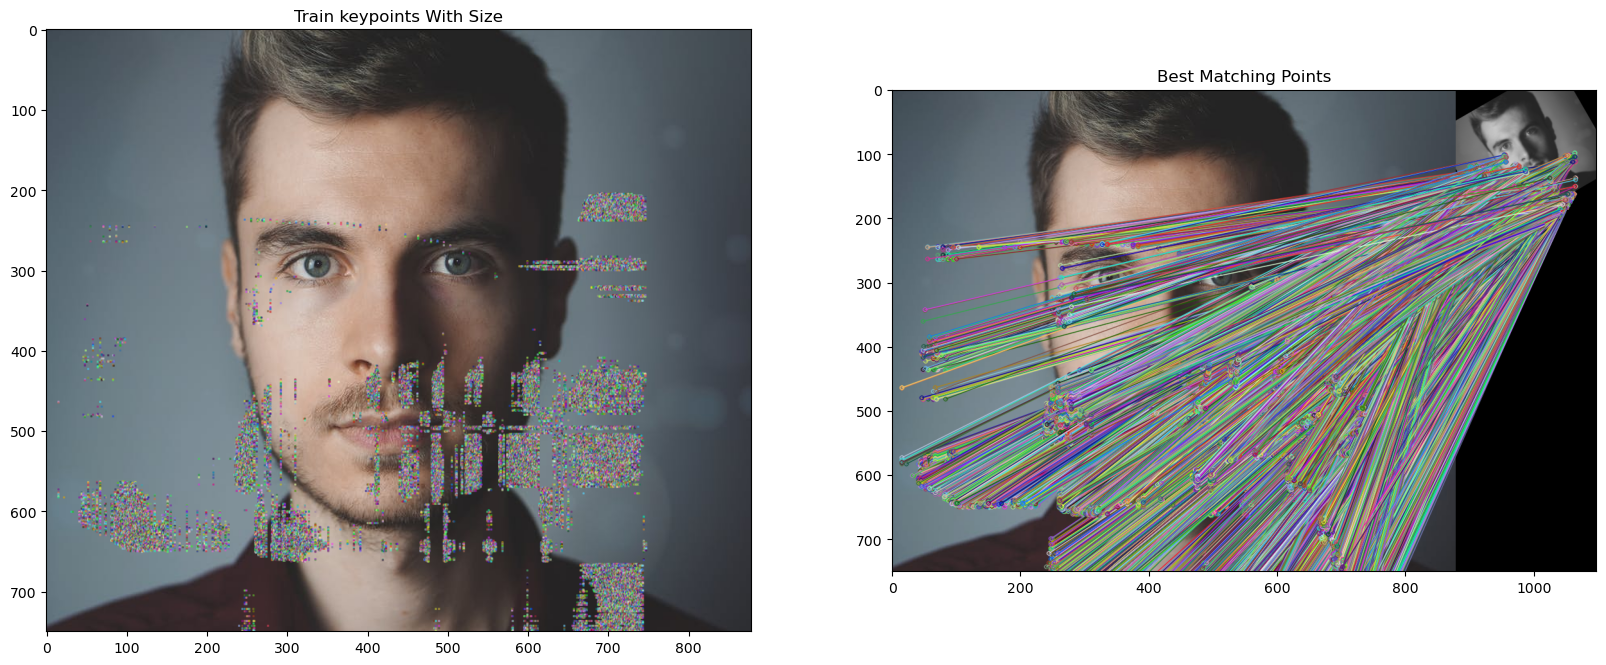


Number of Matching Keypoints Between The Training and Query Images:  53245


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Custom simplified SURF implementation
def integral_image(img):
    return np.cumsum(np.cumsum(img, axis=0), axis=1)

def hessian_response(img, x, y, size):
    Dxx = img[x + size, y] + img[x - size, y] - 2 * img[x, y]
    Dyy = img[x, y + size] + img[x, y - size] - 2 * img[x, y]
    Dxy = img[x + size, y + size] + img[x - size, y - size] - img[x + size, y - size] - img[x - size, y + size]
    return Dxx * Dyy - (0.9 * Dxy) ** 2

def detect_interest_points(img, threshold=400):
    integral = integral_image(img)
    points = []
    for x in range(1, img.shape[0] - 1):
        for y in range(1, img.shape[1] - 1):
            if hessian_response(integral, x, y, 1) > threshold:
                points.append((x, y))
    return points

def assign_orientation(img, points):
    orientations = []
    for (x, y) in points:
        region = img[x-2:x+3, y-2:y+3]
        gradient_x = np.gradient(region, axis=1)
        gradient_y = np.gradient(region, axis=0)
        angle = np.arctan2(gradient_y, gradient_x)
        orientations.append((x, y, np.mean(angle)))
    return orientations

def extract_descriptors(img, points):
    descriptors = []
    for (x, y, orientation) in points:
        region = img[x-8:x+9, y-8:y+9]
        gradient_x = np.gradient(region, axis=1)
        gradient_y = np.gradient(region, axis=0)
        magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
        angle = np.arctan2(gradient_y, gradient_x) - orientation
        descriptor = np.histogram(angle, bins=8, weights=magnitude)[0]
        descriptors.append(descriptor)
    return descriptors

# Load the image
image1 = cv2.imread('/home/mds3/Downloads/face1.jpeg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image = cv2.pyrDown(training_image)
test_image = cv2.pyrDown(test_image)
num_rows, num_cols = test_image.shape[:2]

rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display training image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20, 10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)

# Detect keypoints and Create Descriptor
train_keypoints = detect_interest_points(training_gray)
train_keypoints_oriented = assign_orientation(training_gray, train_keypoints)
train_descriptor = extract_descriptors(training_gray, train_keypoints_oriented)

test_keypoints = detect_interest_points(test_gray)
test_keypoints_oriented = assign_orientation(test_gray, test_keypoints)
test_descriptor = extract_descriptors(test_gray, test_keypoints_oriented)

# Draw keypoints on the image
keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, [cv2.KeyPoint(x, y, 1) for (x, y) in train_keypoints], keypoints_without_size, color=(0, 255, 0))
cv2.drawKeypoints(training_image, [cv2.KeyPoint(x, y, 1) for (x, y, _) in train_keypoints_oriented], keypoints_with_size, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20, 10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

# Matching Keypoints

# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)

# Convert descriptors to the correct format for BFMatcher
train_descriptor = np.array(train_descriptor).astype(np.float32)
test_descriptor = np.array(test_descriptor).astype(np.float32)

# Perform the matching between the SURF descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key=lambda x: x.distance)

result = cv2.drawMatches(training_image, [cv2.KeyPoint(x, y, 1) for (x, y) in train_keypoints], test_gray, [cv2.KeyPoint(x, y, 1) for (x, y) in test_keypoints], matches, test_gray, flags=2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))


In [3]:
surf = cv2.xfeatures2d.SURF_create(800)

error: OpenCV(4.9.0) /io/opencv_contrib/modules/xfeatures2d/src/surf.cpp:1026: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'
